In [21]:
import os
import re
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ---------- Mixed precision (helps a lot on NVIDIA GPUs with Tensor Cores) ----------
try:
    mixed_precision.set_global_policy("mixed_float16")
except Exception:
    pass


class MedicalChatbot:
    def __init__(self, data_dir=r'C:\Users\User\Downloads\medicalimages', model_path='pneumonia_model.h5'):
        self.data_dir = data_dir
        self.train_dir = os.path.join(data_dir, 'chestxray', 'train')
        self.test_dir = os.path.join(data_dir, 'chestxray', 'test')
        self.model = None
        self.model_path = model_path

        # speed-friendly settings
        self.img_size = (160, 160)
        self.batch_size = 32

        # Medical knowledge base
        self.knowledge = {
            'pneumonia': {
                'definition': 'Pneumonia is an infection that inflames the air sacs in one or both lungs.',
                'symptoms': ['cough with phlegm', 'fever', 'chills', 'difficulty breathing', 'chest pain', 'fatigue', 'nausea'],
                'causes': ['bacteria', 'viruses', 'fungi'],
                'treatment': 'Antibiotics for bacterial pneumonia, antiviral medications for viral pneumonia, rest, fluids, and oxygen therapy if needed.',
                'prevention': 'Vaccination, good hygiene, avoiding smoking, and maintaining a healthy immune system.'
            },
            'normal': {
                'definition': 'A normal chest X-ray shows healthy lungs with no signs of infection or abnormalities.',
                'indicators': ['clear lung fields', 'normal heart size', 'no fluid accumulation', 'normal bone structure']
            }
        }

        # Always train new model
        self._train_model()

    # ---------- Model ----------
    def _build_model(self):
        base = mobilenet_v2.MobileNetV2(
            weights="imagenet",
            include_top=False,
            input_shape=(self.img_size[0], self.img_size[1], 3)
        )
        base.trainable = False  # fast training

        preprocess = mobilenet_v2.preprocess_input
        aug = tf.keras.Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.05),
            RandomZoom(0.1),
        ])

        inp = Input(shape=(self.img_size[0], self.img_size[1], 3))
        x = aug(inp)
        x = preprocess(x)
        x = base(x, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation="sigmoid", dtype="float32")(x)

        model = Model(inp, out)
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        return model

    def _make_datasets(self):
        train_ds = tf.keras.utils.image_dataset_from_directory(
            self.train_dir,
            image_size=self.img_size,
            batch_size=self.batch_size,
            label_mode="binary",
            shuffle=True
        )
        val_ds = tf.keras.utils.image_dataset_from_directory(
            self.test_dir,
            image_size=self.img_size,
            batch_size=self.batch_size,
            label_mode="binary",
            shuffle=False
        )

        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
        val_ds = val_ds.cache().prefetch(AUTOTUNE)
        return train_ds, val_ds

    # ---------- Train ----------
    def _train_model(self):
        print("⚡ Training new model (MobileNetV2 + tf.data)...")
        train_ds, val_ds = self._make_datasets()
        self.model = self._build_model()

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
            ModelCheckpoint(self.model_path, monitor="val_accuracy", save_best_only=True, verbose=1),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        ]

        self.model.fit(
            train_ds,
            epochs=2,
            validation_data=val_ds,
            callbacks=callbacks,
            verbose=2
        )

        results = self.model.evaluate(val_ds, verbose=0)
        print(f"\n✓ Training completed!")
        print(f"📊 Accuracy: {results[1]*100:.2f}%")
        print(f"💾 Model saved to {self.model_path}\n")


# ---------- Main ----------
if __name__ == "__main__":
    chatbot = MedicalChatbot(data_dir=r'C:\Users\User\Downloads\medicalimages')


⚡ Training new model (MobileNetV2 + tf.data)...
Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Epoch 1/2

Epoch 1: val_accuracy improved from -inf to 0.87660, saving model to pneumonia_model.h5


163/163 - 307s - 2s/step - accuracy: 0.9126 - loss: 0.2320 - precision_6: 0.9362 - recall_6: 0.9468 - val_accuracy: 0.8766 - val_loss: 0.2908 - val_precision_6: 0.9151 - val_recall_6: 0.8846 - learning_rate: 0.0010
Epoch 2/2

Epoch 2: val_accuracy improved from 0.87660 to 0.88622, saving model to pneumonia_model.h5


163/163 - 288s - 2s/step - accuracy: 0.9450 - loss: 0.1358 - precision_6: 0.9595 - recall_6: 0.9667 - val_accuracy: 0.8862 - val_loss: 0.2913 - val_precision_6: 0.9346 - val_recall_6: 0.8795 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.

✓ Training completed!
📊 Accuracy: 87.66%
💾 Model saved to pneumonia_model.h5



In [24]:
# Save to specific path (no need to re-evaluate here)
save_path = r"C:\Users\User\Downloads\my_models\pneumonia_model.h5"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # create folder if not exists
chatbot.model.save(save_path)

print(f"💾 Model saved to {save_path}\n")

💾 Model saved to C:\Users\User\Downloads\my_models\pneumonia_model.h5



Found 5216 files belonging to 2 classes.


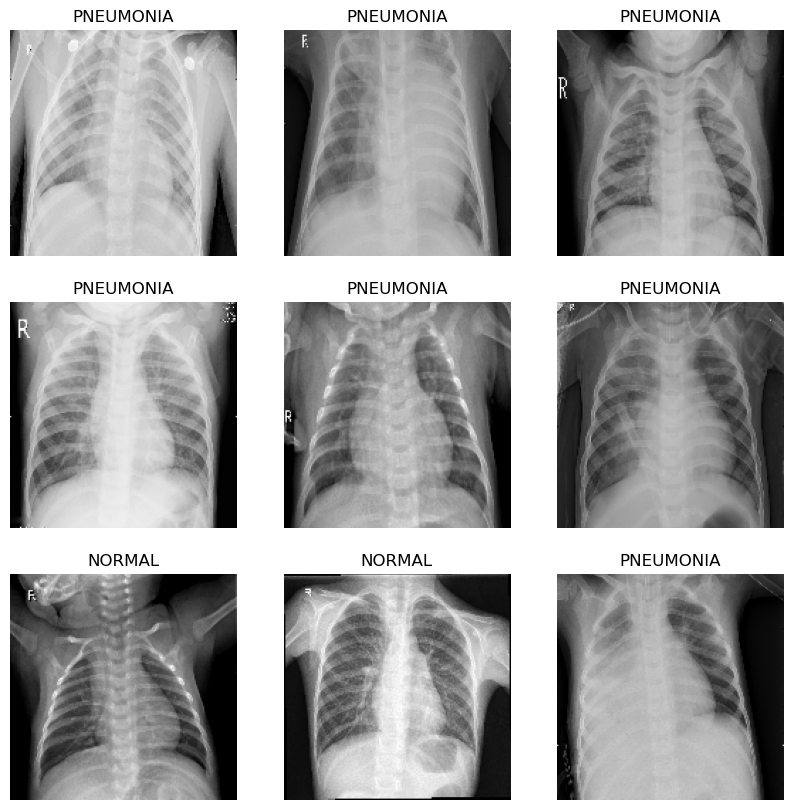

In [25]:
import matplotlib.pyplot as plt

# Load a small batch from your dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\User\Downloads\medicalimages\chestxray\train",
    image_size=(160, 160),
    batch_size=9,   # grab 9 images
    label_mode="binary",
    shuffle=True
)

# Get one batch
images, labels = next(iter(dataset))

# Plot
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = "PNEUMONIA" if labels[i].numpy() == 1 else "NORMAL"
    plt.title(label)
    plt.axis("off")
plt.show()
